**Face Mask Segmentation**

**Dataset**

Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

**Mount Google drive if you are using google colab**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Change current working directory to project folder**

In [4]:
import os
project_path="/content/drive/My Drive/FM/images.npy"

In [5]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.2.0'

**Load the "images.npy" file**

In [6]:
import numpy as np
data= np.load("/content/drive/My Drive/FM/images.npy",allow_pickle=True)

**Check one sample from the loaded "images.npy" file**

In [7]:
data.shape

(409, 2)

In [8]:
print(data[10][1])

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.48, 'y': 0.10385756676557864}, {'x': 0.7716666666666666, 'y': 0.6795252225519288}], 'imageWidth': 600, 'imageHeight': 337}]


In [9]:
print(data[20][1])

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.4979166666666667, 'y': 0.20833333333333334}, {'x': 0.7854166666666667, 'y': 0.6888888888888889}], 'imageWidth': 480, 'imageHeight': 360}]


**Set image dimensions**

Initialize image height, image width with value: 224

In [10]:
IMAGE_WIDTH =224
IMAGE_HEIGHT = 224

**Create features and labels**

-Here feature is the image

-The label is the mask

-Images will be stored in "X_train" array

-Masks will be stored in "masks" array

In [11]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

**Print the shape of X_train and mask array**

In [12]:
print(X_train.shape)

(409, 224, 224, 3)


In [13]:
print(masks.shape)

(409, 224, 224)


**Creating validation data**

In [14]:
from sklearn.model_selection import train_test_split

# Split train and valid
x_train, x_valid, y_train, y_valid = train_test_split(X_train, masks, test_size=0.15, random_state=2)

In [15]:
print(x_valid.shape)

(62, 224, 224, 3)


**Print a sample image and image array**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.96862745 -0.96862745 -0.96862745]
  [-0.96078432 -0.96078432 -0.96078432]
  [-0.96078432 -0.96078432 -0.96078432]]

 [

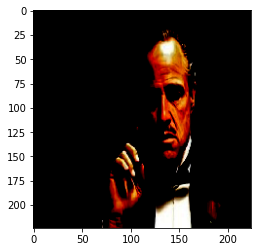

In [16]:
from matplotlib import pyplot
n = 10
print(X_train[n])
pyplot.imshow(X_train[n])

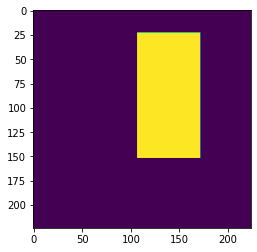

In [17]:
pyplot.imshow(masks[n])

**Create the model**
* Add MobileNet as model with below parameter values

input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3

include_top: False

alpha: 1.0

weights: "imagenet"

* Add UNET architecture layers

This is the trickiest part of the project, you need to research and implement it correctly

In [18]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model

ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights='imagenet') # Load pre-trained mobilenet
    for layer in model.layers:
        layer.trainable = trainable
    
    block = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block])
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)

    x = Reshape((IMAGE_HEIGHT, IMAGE_HEIGHT))(x)

    return Model(inputs=model.input, outputs=x)


  

**Call the create_model function**

In [19]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model()

# Print summary
model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
_____________________________

**Define dice coefficient function**

In [20]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

**Define loss**

In [21]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

**Compile the model**
* Complie the model using below parameters

loss: use the loss function defined above

optimizers: use Adam optimizer

metrics: use dice_coefficient function defined above

In [22]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

**Define checkpoint and earlystopping**

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

**Fit the model**
- Fit the model using below parameters

   -epochs: you can decide

   -batch_size: 1

   -callbacks: checkpoint, reduce_lr, stop

In [26]:
model.fit(x_train, y_train, validation_data=(x_valid,y_valid), epochs=10, batch_size = 1, verbose=1)

Epoch 1/10
347/347 [==============================] - 13s 38ms/step - loss: 1.3789 - dice_coefficient: 0.4337 - val_loss: 1.4503 - val_dice_coefficient: 0.4363
Epoch 2/10
347/347 [==============================] - 13s 37ms/step - loss: 0.8120 - dice_coefficient: 0.6060 - val_loss: 1.5094 - val_dice_coefficient: 0.4315
Epoch 3/10
347/347 [==============================] - 13s 37ms/step - loss: 0.6722 - dice_coefficient: 0.6556 - val_loss: 1.1316 - val_dice_coefficient: 0.5217
Epoch 4/10
347/347 [==============================] - 13s 37ms/step - loss: 0.5835 - dice_coefficient: 0.6925 - val_loss: 1.1044 - val_dice_coefficient: 0.5372
Epoch 5/10
347/347 [==============================] - 13s 37ms/step - loss: 0.5640 - dice_coefficient: 0.7039 - val_loss: 0.9051 - val_dice_coefficient: 0.5871
Epoch 6/10
347/347 [==============================] - 13s 37ms/step - loss: 0.5059 - dice_coefficient: 0.7276 - val_loss: 0.9280 - val_dice_coefficient: 0.5901
Epoch 7/10
347/347 [====================

**Get the predicted mask for a sample image**

In [ ]:
model.evaluate(x_valid, y_valid,verbose=1)

In [37]:
n = 10
sample_image = x_train[n]


**Impose the mask on the image**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


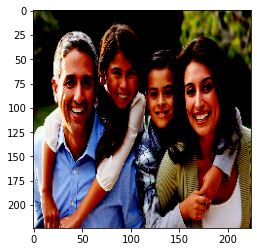

In [38]:
plt.imshow(sample_image)

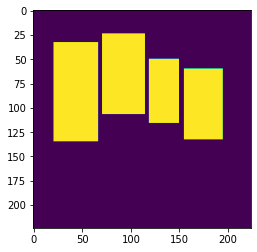

In [39]:
plt.imshow(y_train[10])